In [12]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Layer, Lambda, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from datetime import datetime
from collections import deque
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import itertools
import copy
import random
import pickle
import time
import os
import io
from importnb import Notebook, reload
with Notebook(): 
    import Utilities

# This removes error from the custom keras-layer
tf.compat.v1.disable_eager_execution()

In [13]:
# Specify the path to OneDrive
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")

config = {
    'embed_dim': 300,    # Dimensions to use for the word embedding
    'lookback': 3,       # How far back to collect data in the recurrent layer (days)
    'delay': 1,          # How far ahead to predict data (days)
    'batch_size': 10,    # Batch size used in generator
    'p': 1,              # Order of the AR-part of the model
    'd': 1,              # Integrated order
    'q': 1,              # Included moving average terms 
    'train_part' : 0.8,  # Part of data to be used for training
    'val_part' : 0.1,    # Part of data to be used for validation
    'test_part' : 0.1,   # Part of data to be used for testing
    'series': 'S&P',     # What series we currently want to predict, '1 YEAR', '3 YEAR' or 'S&P'
    'vocab_size': 15000, # Include only the 'vocab_size' most common words 
    'start_date': '2006-10-20',
    'end_date': '2013-11-19',
}

In [14]:
# Load data 
news_path = ONEDRIVE_PATH / "Input Data/financial_headlines_20061020-20131119.pkl"
data = pd.DataFrame(pd.read_pickle(news_path))
data.set_index('date',inplace=True)
text = Utilities.preprocess_text(data)

In [15]:
# Tokenize the text data 
tokenizer = Tokenizer(num_words=config['vocab_size'])
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(text)

In [16]:
# Load dictionary of embeddings for this vocabulary (previously constructed)
subset_embeddings = ONEDRIVE_PATH / "Embeddings/GloVe/saved.42B.300d.pkl"
with open(subset_embeddings,'rb') as handle: 
    emb_dict = pickle.load(handle)

In [17]:
# Create embedding matrix with shape (vocab_size, embed_dimension)
embedding_weights = np.zeros((config['vocab_size'], config['embed_dim']))
# Add pre-trained weights from GloVe
for word,index in word_index.items(): 
    if index > config['vocab_size']: 
        break
    temp_emb = emb_dict.get(word)
    if temp_emb is not None: 
        embedding_weights[index - 1] = temp_emb
    else: 
        embedding_weights[index - 1] = np.random.normal(size=config['embed_dim'])

In [18]:
config['max_len'] = max([len(sent) for sent in sequences])
print("Maximum length of one day news:",config['max_len'])

# Pad the text data so we get a matrix of shape (n,d)
x = np.zeros((len(sequences), config['max_len']))
for i,sent in enumerate(sequences): 
    if len(sent) > config['max_len']: 
        x[i] = sent[:config['max_len']]
    else: 
        x[i,:len(sent)] = sent

Maximum length of one day news: 950


In [19]:
y = Utilities.load_direction_labels(config)

# Remove last row of the x-matrix, since there's no label for that entry
if x.shape[0] != len(y): 
    x = x[:-1]

In [20]:
(x_train,y_train), (x_test, y_test) = Utilities.shuffle_and_partition(x,y, test_part=0.2)
print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)

Shape of x_train:  (2064, 950)
Shape of y_train:  (2064,)


## Model
We create a model similar to the one in "MLP-PreTrained", except for the initial Embedding-layer from Keras. A custom layer is defined to average the embedding of all words in one training sample after the embedding layer. 

In [21]:
# Define some help functions for custom layer and hyper parameter optimization

# Create functions for custom 'MergeEmedding'-layer which averages 
# the embeddings over all words after the embedding layer 
def merge_embeddings(x):
    # Sum the embeddings for every word slot. If this is zero, there is no word in this slot
    non_zero = K.sum(K.cast(K.not_equal(K.sum(x,axis=2),0),tf.float32))
    return K.sum(x,axis=1) / non_zero

def merge_output_shape(input_shape):
    return input_shape[0], input_shape[-1]

def create_nn(n_nodes, lr=0.01): 
    # n_nodes is a list with the number of nodes per layer, starting from the input 
    model = Sequential() 
    model.add(Embedding(input_dim=config['vocab_size'],
                       output_dim=config['embed_dim'],
                        input_length=config['max_len'],
                       weights=[embedding_weights]))
    model.add(Lambda(merge_embeddings, output_shape=merge_output_shape))
    for n in n_nodes: 
        model.add(Dense(n))
    model.add(Dense(1,activation='sigmoid'))
    rms = optimizers.RMSprop(learning_rate=lr)
    model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
    return model

def train_and_format(x,y,bs,epochs, results, layers, nodes, lr,verbose=0):
    name = f"{bs}_{layers}_{nodes}"
    temp_history = model.fit(x, y, batch_size=bs, validation_split=0.2, epochs = epochs,verbose=verbose)
    return results.append(pd.Series([np.mean(temp_history.history['val_loss'][-5:]),
                                                temp_history, model, layers, 
                                                nodes, bs, lr], 
                                                name=name,
                                    index=['Mean Val Acc','History','Model','Layers','Nodes','Batch Size','Learning Rate']))


In [23]:
n_layers = [2]
n_nodes = [250, 500, 1000]
learning_rates = [0.01]
batch_sizes = [32]
epochs = 10
results = pd.DataFrame(columns=['Mean Val Acc','History','Model', 'Layers', 'Nodes', 'Batch Size', 'Learning Rate'])
n_configs = sum([len(n_nodes)**l for l in n_layers]) * len(batch_sizes) * len(learning_rates)
ctr = 0
print('Testing {} combinations. '.format(n_configs))
for layers in n_layers:
    # Ugliest code ever written, fix?
    if layers == 1: node_configs = list(itertools.product(n_nodes))
    elif layers == 2: node_configs = list(itertools.product(n_nodes, n_nodes))
    elif layers == 3: node_configs = list(itertools.product(n_nodes, n_nodes, n_nodes))
    elif layers == 4: node_configs = list(itertools.product(n_nodes, n_nodes, n_nodes, n_nodes))
    for bs in batch_sizes: 
        for temp_nodes in node_configs: 
            for lr in learning_rates:
                ctr += 1 
                model = create_nn(temp_nodes, lr)
                results = train_and_format(x_train, y_train, bs, epochs, results, layers, temp_nodes,lr,verbose=0)
                print("{} %     ".format(round(100 * ctr / n_configs,2)),end='\r')


Testing 9 combinations. 


In [25]:
k = 3
print("Top {} configs: ".format(k))
k_best = np.argpartition(results['Mean Val Acc'],-k)[-k:]
results.iloc[k_best]

Top 3 configs: 


,Mean Val Acc,History,Model,Layers,Nodes,Batch Size,Learning Rate
"32_2_(1000, 250)",0.786684,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,2,"(1000, 250)",32,0.01
"32_2_(500, 500)",0.803671,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,2,"(500, 500)",32,0.01
"32_2_(500, 1000)",0.921390,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,2,"(500, 1000)",32,0.01


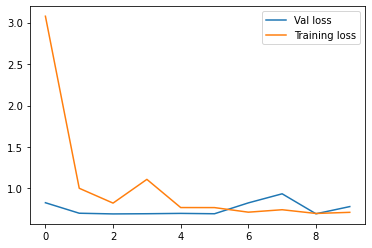

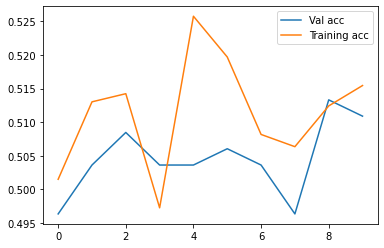

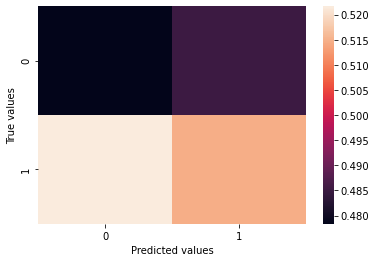

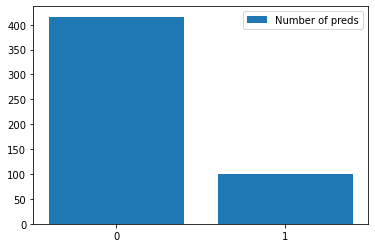

              precision    recall  f1-score   support

         0.0       0.48      0.80      0.60       248
         1.0       0.51      0.19      0.28       269

    accuracy                           0.49       517
   macro avg       0.50      0.50      0.44       517
weighted avg       0.50      0.49      0.43       517

32_2_(1000, 250)


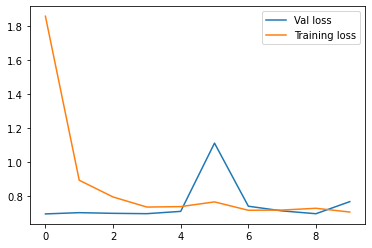

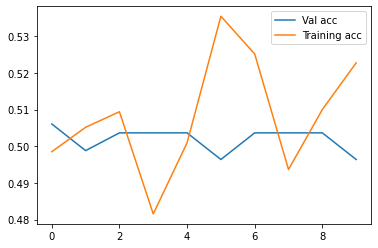

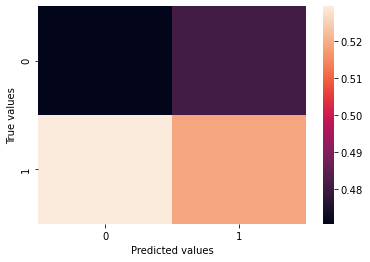

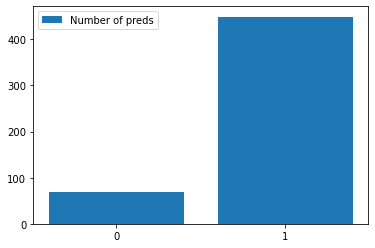

              precision    recall  f1-score   support

         0.0       0.47      0.13      0.20       248
         1.0       0.52      0.87      0.65       269

    accuracy                           0.51       517
   macro avg       0.49      0.50      0.43       517
weighted avg       0.50      0.51      0.43       517

32_2_(500, 500)


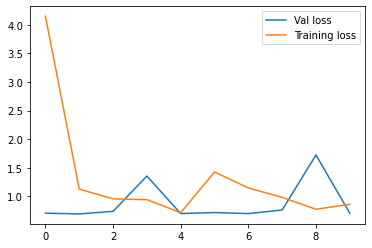

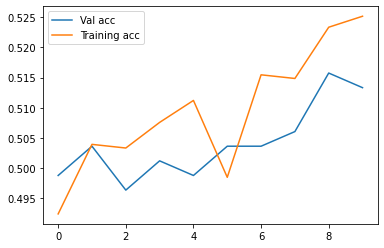

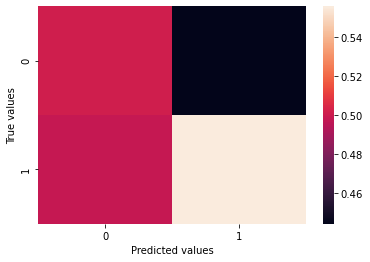

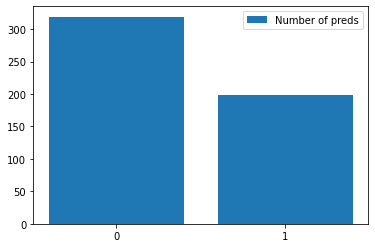

              precision    recall  f1-score   support

         0.0       0.50      0.65      0.56       248
         1.0       0.56      0.41      0.47       269

    accuracy                           0.52       517
   macro avg       0.53      0.53      0.52       517
weighted avg       0.53      0.52      0.52       517

32_2_(500, 1000)


In [26]:
for i in k_best: 
    plt.plot(results.iloc[i]['History'].history['val_loss'],label='Val loss')
    plt.plot(results.iloc[i]['History'].history['loss'],label='Training loss')
    plt.legend()
    plt.show()
    plt.plot(results.iloc[i]['History'].history['val_acc'],label='Val acc')
    plt.plot(results.iloc[i]['History'].history['acc'],label='Training acc')
    plt.legend()
    plt.show()
    model = results.iloc[i]['Model']
    model.evaluate(x_test,y_test,verbose=0)
    y_test_pred = np.round(model.predict(x_test))
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    plt.show()
    y_sums = np.zeros(2)
    y_sums[0] = sum(y_test_pred == 0)
    y_sums[1] = sum(y_test_pred == 1)
    plt.bar([0,1],y_sums,label='Number of preds')
    plt.xticks([0,1])
    plt.legend()
    plt.show()
    print(classification_report(y_test, y_test_pred))
    print(results.index[i])
